## Introduction

This tutorial will introduce you to some basic methods for processing MNIST dataset. The MNIST dataset is a large collection of `handwritten digits` that is commonly used as a benchmark for image recognition algorithms. The images were originally taken from NIST's training dataset and were modified and normalized into a 28x28 image. An example would be:

<img src="https://upload.wikimedia.org/wikipedia/commons/2/27/MnistExamples.png">
Figure 1. Sample MNIST data (Source: Wikipedia - MNIST database)

Each one of the digit listed above is a 28x28 image in the MNIST dataset. There're 60,000 images for the training set and 10,000 for the testing set. Although these images look quite similar to our human eyes, they are quite difficult to differentiate without using Neural Networks by the computers. Our goal of this tutorial is to use the MNIST dataset to gain some understanding of Neural Networks.


### Tutorial content

In this tutorial, we will show how to do some basic image recognition in Python, using [PyTorch](http://pytorch.org). 

GPUs can significantly speed up training because it's designed to do parallel computing and, therefore, quite capable to handle neural network training using Nvidia's CUDA and cuDNN libraries.

We'll be using data collected from the Pittsburgh GIS data repository from the Pittsburgh city planning department: http://pittsburghpa.gov/dcp/gis/gis-data-new.  While there aren't always public repositories for GIS data, a surprisingly large number of cities or counties maintain an up-to-date set of GIS data available on their web pages, and the analysis we do here could be repeated for many other cities as well.

We will cover the following topics in this tutorial:
- [Installing the libraries](#Installing-the-libraries)
- [Loading data](#Loading-data)
- [Visualize data](#Visualize-data)
- [Multiple Layer Perceptrons](#Multiple-Layer-Perceptrons)
- [Training Function](#Training-Function)
- [Testing Function](#Testing-Function)
- [Evaluate Multiple Layer Perceptrons](#Evaluate-Multiple-Layer-Perceptrons)
- [Convolutional Neural Network](#Convolutional-Neural-Network)
- [Evaluate Convolutional Neural Network](#Evaluate-Convolutional-Neural-Network)
- [Comparison](#Comparison)
- [References](#ReferencesExample-application:-Yelp-by-neighborhood)

## Installing the Libraries

Before getting started, you'll need to install the various libraries that we will use. You will need to first install Anaconda environment.

First, check if you have CUDA environment by typing in Terminal:

    $ nvidia-smi
    
If you have the `nvidia-smi` command, you've got a CUDA-enabled GPU and should install the GPU version of PyTorch.

For computers with CUDA 8.0:

    $ conda install pytorch torchvision -c pytorch

For computers with CUDA 9.0:

    $ conda install pytorch torchvision cuda90 -c pytorch

For computers with CUDA 9.1:

    $ conda install pytorch torchvision cuda91 -c pytorch
    
For mac or computers without CUDA:

    $ conda install pytorch torchvision -c pytorch 
    
Take a coffee break and you should've PyTorch installed on your computer.

In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.utils.data as Data
import torchvision
from torch.autograd import Variable
import matplotlib.pyplot as plt
import os

## Loading Data

Now that we've installed and loaded the libraries, let's first download MNIST dataset, load the dataset and visualize it.

We're going to download the data if it doesn't exist from the internet and save it to `./mnist-dataset/`. 

This will download four files from the internet that contains the images and digits for both the training and testing dataset.
    
    > Images for training: http://yann.lecun.com/exdb/mnist/train-images-idx3-ubyte.gz
    > Digits for training: http://yann.lecun.com/exdb/mnist/train-labels-idx1-ubyte.gz
    > Images for testing:  http://yann.lecun.com/exdb/mnist/t10k-images-idx3-ubyte.gz
    > Digits for testing:  http://yann.lecun.com/exdb/mnist/t10k-labels-idx1-ubyte.gz
            

In [2]:
# Directories to save the downloaded MNIST dataset
MNIST_DIRECTORY = './mnist-dataset/'
# Whether to download MNIST dataset
SHOULD_DOWNLOAD_MNIST = not os.path.exists(MNIST_DIRECTORY)

train_dataset = torchvision.datasets.MNIST(
    root=MNIST_DIRECTORY,
    train=True,
    transform=torchvision.transforms.ToTensor(),
    download=SHOULD_DOWNLOAD_MNIST,
)

test_dataset = torchvision.datasets.MNIST(
    root=MNIST_DIRECTORY,
    train=False,
    transform=torchvision.transforms.ToTensor(),
    download=SHOULD_DOWNLOAD_MNIST,
)

Processing...
Done!


In [3]:
tensor, digit = train_dataset[0]
print(type(tensor))
print(type(digit))    

print(tensor.shape)
print('The first digit is: {}'.format(digit))

<class 'torch.FloatTensor'>
<class 'int'>
torch.Size([1, 28, 28])
The first digit is: 5


We can see that the first row of the dataset is a tuple of `(tensor, digit)` where the `digit` is the digit that we're trying to guess. A `tensor` is a mathematical object analogous to but more general than a vector, represented by an array of components that are functions of the coordinates of a space. We can see that the `tensor` is of size `[1, 28, 28]`, allign with the size of the image (28 pixels by 28 pixels). Let's visualize what the numbers look like.

## Visualize Data

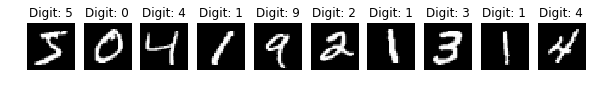

In [4]:
as_image = torchvision.transforms.ToPILImage()

plt.figure(figsize=(10, 1))

for i in range(0, 10):
    tensor, digit = train_dataset[i]
    image = as_image(tensor)
    
    plt.subplot(1,10,i+1)
    plt.axis('off')
    plt.imshow(np.asarray(image), cmap="gray")
    plt.title('Digit: ' + str(digit))

plt.show()


## Brain Neuron and Mutiple Layer Perceptrons

Vision recognition can be tricky for the computer. Let's figure out how our brain process such an image. Our brain receive signals from eye form impulses and feed them into neurons, specialized cells for transmitting nerve impulses. These neurons then process all of the information and forward it onto the other neurons. 

<img src="https://static1.squarespace.com/static/5877e0091b631b1b2c8ac78d/t/58f559619f7456166b64c409/1492474211520/">
Figure 2: Neuron in brain (Source: margreetdeheer.com)

We can use the same idea of brain neurons and use it in machine learning for an architecture we called Multiple Layer Perceptrons. Each perceptron emulate a neuron in that it gets inputs from previous layers, process it and then forward it to later layers. Each layer of perceptron is responsible for different parts of the recognition process. For example, the first layer may be responsible for recognizing direction of strokes whereas the second layer may be responsible for recognizing strokes in each of the digits and the third layers is responsible for combining the parts to form an educated guess of the digit.

<img src="http://ieeexplore.ieee.org/mediastore/IEEE/content/media/7728/7229393/7219432/7219432-fig-2-large.gif">
Figure 3: Multiple Layer Perceptrons (Source: IEEE)

In this example, we will use three layers of perceptrons. The first layer will have 128 neurons, the second layer will have 64 neurons and the last will have 10 neurons to map to the 10 digits. We'll process 1000 images as a single batch. The training errors accumulated over those 1000 images will be used to compute gradients and propagate back to the neurons to change the weights and bias at each batch using [Gradient Descent](https://en.wikipedia.org/wiki/Gradient_descent). Here's a graph of the structure that we're going to use. The inputs will be 1000 images, each with `28 x 28` pixels. We flatten the data into `1000 x 784` pixels and then feed it through a three layers MLP to get an output of `1000 x 10`. The output will be the probability for each of the 10 digits. All that we need to do is to find the one with the highest probability, and that will be our guess for the specific image.

## Multiple Layer Perceptrons

In [5]:
from IPython.display import IFrame
IFrame('http://ethereon.github.io/netscope/#/gist/6ae5406b1fb688756507405a268df68e', width='100%', height=700)

Let's first define our network. In PyTorch, a neural network is a subclass of torch.nn.Module. The use of a ReLU activation function is to provide some non-linearity mapping, allowing the model to respond to the loss that varies non-linearly with its explanatory variables.


In [6]:
class MultipleLayerPerceptrons(nn.Module):
    def __init__(self):
        super(MultipleLayerPerceptrons, self).__init__()
        
        self.layers = nn.ModuleList([
            nn.Linear(28 * 28, 128),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(64, 10),
            nn.Softmax(dim=1)
        ])

    def forward(self, inputs):
        inputs = inputs.view(-1, 28 * 28)  # Flatten data
        
        for layer in self.layers:
            inputs = layer(inputs)
            
        return inputs


## Training Function

To start training, let's initialize a MLP model.

In [7]:
mlp = MultipleLayerPerceptrons()

# Use GPU if available
gpu = torch.cuda.is_available()
if gpu:
    mlp = mlp.cuda()

In the training portion, we're going to randomize the dataset so that our data is different in each iterations to provide some randomness in the order of the images. This can be done via `DataLoader`.

We can initialize a DataLoader by:

    $ batch_size = 32
    
    $ train_dataloader = torch.utils.data.DataLoader(train, batch_size=batch_size, shuffle=True)
    
    $ test_dataloader  = torch.utils.data.DataLoader(test, batch_size=batch_size, shuffle=False)

After that, we need to use an optimizer algorithm to do the calculation. In this example, we'll use Adam, which is a variant of Graidient Descent algorithm. And we will give it a learning rate of 0.01 to make sure it won't bounce out of a solution.

    $ optimizer = torch.optim.Adam(mlp.parameters(), lr=0.001)
    
After that, we need to determine how we're going to calculate loss. Here, we're using CrossEntropyLoss

    $ loss_fn = nn.CrossEntropyLoss()
    

In [8]:
batch_size = 1000

train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

test_dataloader  = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

optimizer = torch.optim.Adam(mlp.parameters(), lr=0.001)

loss_fn = nn.CrossEntropyLoss()    

After that, we can start constructing our train function. The function takes in an optional argument of epoch, meaning how many iterations we want to run the training protocol.

In [9]:
print_interval = 10

def train(start_epoch=0, num_epochs=1, model=mlp, optimizer=optimizer):
    # Set model to 'train' mode to enable Dropout
    model.train()
    
    epoch_losses = []
    for epoch in range(start_epoch, start_epoch + num_epochs):
        # Create local variables
        losses = []
        
        for i, (x, y) in enumerate(train_dataloader):
            # Enable GPU when available
            if gpu:
                x, y = x.cuda(), y.cuda()
                
            # Wrap the data in Variable class to be passed into nn.Module
            x, y = Variable(x), Variable(y)
            
            # Zero the optimizer's gradient
            optimizer.zero_grad()
            
            # Feed the data to the model
            y_hat = model(x)
            
            # Compute loss using loss function
            loss = loss_fn(y_hat, y.long())
            losses.append(loss.data.cpu().numpy())
            
            # Back propagate loss
            loss.backward()
            optimizer.step()
        
            # Log loss for every 'print_interval'
            if (i + 1) % print_interval == 0:
                print('<Train> : Epoch: {:2} | Batch: {:4}/{:4} | Loss: {:.6f}'.format(
                    epoch + 1, (i + 1) * batch_size, len(train_dataset), np.mean(losses)))
        
        print()
        epoch_losses.append(losses)

    return epoch_losses

Since we want to measure our performance after each epoch, let's wait until we finished our testing function to run the training protocol.

## Testing Function

Now that we have our trained function. It's time to write a test function. We can then use the train and test functions to evaluate how well we're doing.

In [10]:
def test(epoch=0, model=mlp):
    # Change model mode to 'eval' to disable Dropout
    model.eval()
    
    total_correct = 0
    losses, percentages = [], []
    for x, y in test_dataloader:
        # Enable GPU if available
        if gpu:
            x, y = x.cuda(), y.cuda()
        
        # Wrap it in a Variable
        x, y = Variable(x), Variable(y)
        
        # Pass it through the model
        y_hat = model(x)
        
        # Compute loss
        loss = loss_fn(y_hat, y.long())
        losses.append(loss.data.cpu().numpy())
        
        # Make an educated guess
        y_hat = y_hat.data.max(1)[1]

        # Compare results and compute percentage
        correct = y_hat.eq(y.data).cpu().sum()
        total_correct += correct
        percentage = 100.0 * correct / batch_size
        percentages.append(percentage)
    
    print('<Test>  : Epoch {:2} | {:5} / {:5} Correct! ({:.2f} %) | Loss: {:.6f}'.format(
        epoch + 1, total_correct, len(test_dataset), 100. * total_correct / len(test_dataset), np.mean(losses)))
    
    return losses, percentages


Now that we have completed both functions. Let's do some benchmarks.

## Evaluate Multiple Layer Perceptrons

For this section, we're going to run our model for 20 epochs and record training loss, testing loss and testing accuracy.

In [11]:
%%time

num_epochs = 20
train_x, train_losses = [], []
test_x, test_losses, test_percentages = [], [], []
for i in range(num_epochs):
    %%time losses = train(i)
    train_x += list(np.arange(i, i + 1, 1. / (len(train_dataset) / batch_size)))
    train_losses += losses[0]
    
    print()
    
    %%time losses, percentages = test(i)
    test_x += list(np.arange(i, i + 1, 1. / (len(test_dataset) / batch_size)))
    test_losses += losses
    test_percentages += percentages
    
    print()


<Train> : Epoch:  1 | Batch: 10000/60000 | Loss: 2.286287
<Train> : Epoch:  1 | Batch: 20000/60000 | Loss: 2.240360
<Train> : Epoch:  1 | Batch: 30000/60000 | Loss: 2.168818
<Train> : Epoch:  1 | Batch: 40000/60000 | Loss: 2.090689
<Train> : Epoch:  1 | Batch: 50000/60000 | Loss: 2.027307
<Train> : Epoch:  1 | Batch: 60000/60000 | Loss: 1.977394

CPU times: user 2.34 s, sys: 72.4 ms, total: 2.41 s
Wall time: 2.41 s

<Test>  : Epoch  1 |  8121 / 10000 Correct! (81.21 %) | Loss: 1.672003
CPU times: user 377 ms, sys: 41 µs, total: 377 ms
Wall time: 377 ms

<Train> : Epoch:  2 | Batch: 10000/60000 | Loss: 1.699335
<Train> : Epoch:  2 | Batch: 20000/60000 | Loss: 1.691201
<Train> : Epoch:  2 | Batch: 30000/60000 | Loss: 1.684052
<Train> : Epoch:  2 | Batch: 40000/60000 | Loss: 1.679199
<Train> : Epoch:  2 | Batch: 50000/60000 | Loss: 1.674841
<Train> : Epoch:  2 | Batch: 60000/60000 | Loss: 1.671203

CPU times: user 2.28 s, sys: 39.6 ms, total: 2.32 s
Wall time: 2.32 s

<Test>  : Epoch  2 |

<Test>  : Epoch 15 |  9616 / 10000 Correct! (96.16 %) | Loss: 1.501267
CPU times: user 364 ms, sys: 3.8 ms, total: 368 ms
Wall time: 368 ms

<Train> : Epoch: 16 | Batch: 10000/60000 | Loss: 1.505593
<Train> : Epoch: 16 | Batch: 20000/60000 | Loss: 1.506244
<Train> : Epoch: 16 | Batch: 30000/60000 | Loss: 1.506364
<Train> : Epoch: 16 | Batch: 40000/60000 | Loss: 1.506121
<Train> : Epoch: 16 | Batch: 50000/60000 | Loss: 1.505810
<Train> : Epoch: 16 | Batch: 60000/60000 | Loss: 1.505701

CPU times: user 2.33 s, sys: 40.1 ms, total: 2.37 s
Wall time: 2.36 s

<Test>  : Epoch 16 |  9631 / 10000 Correct! (96.31 %) | Loss: 1.499758
CPU times: user 376 ms, sys: 0 ns, total: 376 ms
Wall time: 375 ms

<Train> : Epoch: 17 | Batch: 10000/60000 | Loss: 1.505345
<Train> : Epoch: 17 | Batch: 20000/60000 | Loss: 1.505340
<Train> : Epoch: 17 | Batch: 30000/60000 | Loss: 1.504826
<Train> : Epoch: 17 | Batch: 40000/60000 | Loss: 1.504437
<Train> : Epoch: 17 | Batch: 50000/60000 | Loss: 1.503828
<Train> : 

Finally, we can plot he performance using the data we just generated.

Let's plot our training loss over time first.

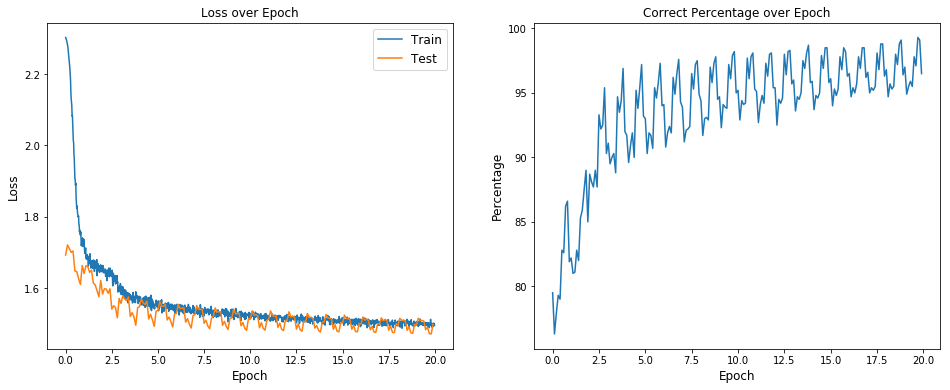

In [22]:
fig = plt.figure(figsize=(16, 6))

s1 = fig.add_subplot(121)
s1.set_title('Loss over Epoch', fontsize=12)
s1.set_xlabel('Epoch', fontsize=12)
s1.set_ylabel('Loss', fontsize=12)
s1.plot(train_x, train_losses, label='Train')
s1.plot(test_x, test_losses, label='Test')
s1.legend(['Train', 'Test'], loc='upper right', fontsize=12)

s2 = fig.add_subplot(122)
s2.set_title('Correct Percentage over Epoch', fontsize=12)
s2.set_xlabel('Epoch', fontsize=12)
s2.set_ylabel('Percentage', fontsize=12)
s2.plot(test_x, test_percentages, label='Test')
plt.show()

## Convolutional Neural Network

Now that we have our control group, MLP. Let's take a step further to think about how we can be able to use a neural network to detect a similar pattern but shifted towards some directions by some pixels. 

MLP certainly won't help because the pixels are going to be different. We need to think of a clever way to scan through the image. Luckily, we have Convolutional Neural Network (CNN) to help us out.

Here's how Convolutional Neural Network works:
<img src="https://cdn-images-1.medium.com/max/1600/1*_34EtrgYk6cQxlJ2br51HQ.gif">
Figure 4: Convolutional Neural Network (Source: medium.com)

Essentially, it scans through different parts of the image and generate features for each the scans. Each features can be used to detect certain behaviours in the image. The weights and bias of those little matrix can also be trained using back propagation. Hence, this should help us find images that are similar but shifted in some directions.


Let's define the model first.

In [13]:
IFrame('http://ethereon.github.io/netscope/#/gist/1acb81d174a9b4a2b40abaa71a35cd1d', width='100%', height=800)

In order to pass the results from Convolution Neural Network to a Linear layer, we first need to create a FlattenLayer.

In [14]:
class Flatten(nn.Module):
    def forward(self, inputs):
        return inputs.view(inputs.size(0), -1)

Now, we're ready to build our model.

In [15]:
class ConvolutionalNeuralNetwork(nn.Module):
    def __init__(self):
        super(ConvolutionalNeuralNetwork, self).__init__()
        
        self.layers = nn.ModuleList([
            nn.Sequential(
                nn.Conv2d(
                    in_channels=1,
                    out_channels=64,
                    kernel_size=5,
                    stride=1,
                    padding=2
                ),
                nn.BatchNorm2d(64),
                nn.ReLU(),
                nn.MaxPool2d(kernel_size=2)
            ),
            nn.Sequential(
                nn.Conv2d(
                    in_channels=64,
                    out_channels=128,
                    kernel_size=5,
                    stride=1,
                    padding=2
                ),
                nn.BatchNorm2d(128),
                nn.ReLU(),
                nn.MaxPool2d(kernel_size=2)
            ),
            Flatten(),
            nn.Linear(128 * 7 * 7, 10)
        ])

    def forward(self, inputs):
        for layer in self.layers:
            inputs = layer(inputs)
            
        return inputs

We then create a convolutional neural network.

In [16]:
cnn = ConvolutionalNeuralNetwork()

if gpu:
    cnn = cnn.cuda()

## Evaluate Convolutional Neural Network

Now, let's use the training and testing function above to do the evaluation.

In [17]:
%%time

cnn_optimizer = torch.optim.Adam(cnn.parameters(), lr=0.001)

num_epochs = 20
cnn_train_x, cnn_train_losses = [], []
cnn_test_x, cnn_test_losses, cnn_test_percentages = [], [], []
for i in range(num_epochs):
    %%time losses = train(i, model=cnn, optimizer=cnn_optimizer)
    cnn_train_x += list(np.arange(i, i + 1, 1. / (len(train_dataset) / batch_size)))
    cnn_train_losses += losses[0]
    
    print()
    
    %%time losses, percentages = test(i, model=cnn)
    cnn_test_x += list(np.arange(i, i + 1, 1. / (len(test_dataset) / batch_size)))
    cnn_test_losses += losses
    cnn_test_percentages += percentages
    
    print()

<Train> : Epoch:  1 | Batch: 10000/60000 | Loss: 1.240782
<Train> : Epoch:  1 | Batch: 20000/60000 | Loss: 0.795242
<Train> : Epoch:  1 | Batch: 30000/60000 | Loss: 0.601646
<Train> : Epoch:  1 | Batch: 40000/60000 | Loss: 0.488626
<Train> : Epoch:  1 | Batch: 50000/60000 | Loss: 0.415135
<Train> : Epoch:  1 | Batch: 60000/60000 | Loss: 0.362841

CPU times: user 3.81 s, sys: 741 ms, total: 4.55 s
Wall time: 4.55 s

<Test>  : Epoch  1 |  9744 / 10000 Correct! (97.44 %) | Loss: 0.094927
CPU times: user 548 ms, sys: 52 ms, total: 600 ms
Wall time: 599 ms

<Train> : Epoch:  2 | Batch: 10000/60000 | Loss: 0.085570
<Train> : Epoch:  2 | Batch: 20000/60000 | Loss: 0.083705
<Train> : Epoch:  2 | Batch: 30000/60000 | Loss: 0.080312
<Train> : Epoch:  2 | Batch: 40000/60000 | Loss: 0.076888
<Train> : Epoch:  2 | Batch: 50000/60000 | Loss: 0.073637
<Train> : Epoch:  2 | Batch: 60000/60000 | Loss: 0.071286

CPU times: user 3.48 s, sys: 633 ms, total: 4.11 s
Wall time: 4.11 s

<Test>  : Epoch  2 |  

<Test>  : Epoch 15 |  9923 / 10000 Correct! (99.23 %) | Loss: 0.024469
CPU times: user 510 ms, sys: 84.2 ms, total: 594 ms
Wall time: 593 ms

<Train> : Epoch: 16 | Batch: 10000/60000 | Loss: 0.002571
<Train> : Epoch: 16 | Batch: 20000/60000 | Loss: 0.002758
<Train> : Epoch: 16 | Batch: 30000/60000 | Loss: 0.002611
<Train> : Epoch: 16 | Batch: 40000/60000 | Loss: 0.002575
<Train> : Epoch: 16 | Batch: 50000/60000 | Loss: 0.002585
<Train> : Epoch: 16 | Batch: 60000/60000 | Loss: 0.002541

CPU times: user 3.61 s, sys: 540 ms, total: 4.15 s
Wall time: 4.14 s

<Test>  : Epoch 16 |  9922 / 10000 Correct! (99.22 %) | Loss: 0.025765
CPU times: user 542 ms, sys: 56.2 ms, total: 598 ms
Wall time: 597 ms

<Train> : Epoch: 17 | Batch: 10000/60000 | Loss: 0.002214
<Train> : Epoch: 17 | Batch: 20000/60000 | Loss: 0.002048
<Train> : Epoch: 17 | Batch: 30000/60000 | Loss: 0.002311
<Train> : Epoch: 17 | Batch: 40000/60000 | Loss: 0.002334
<Train> : Epoch: 17 | Batch: 50000/60000 | Loss: 0.002341
<Train>

Now, let's plot the same graph.

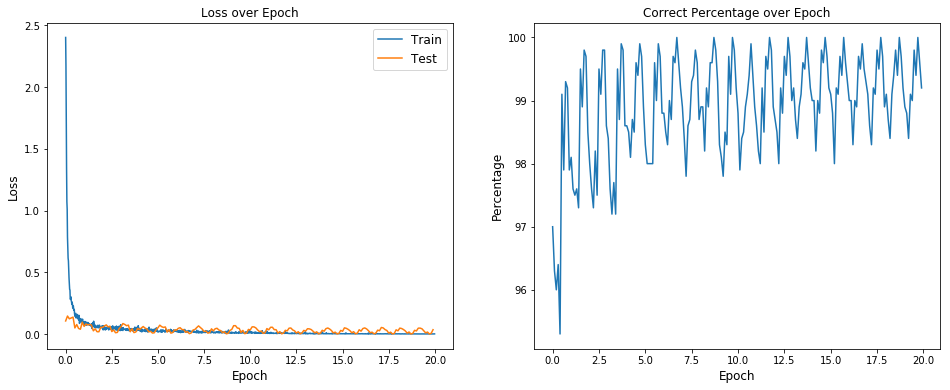

In [21]:
fig = plt.figure(figsize=(16, 6))

s1 = fig.add_subplot(121)
s1.set_title('Loss over Epoch', fontsize=12)
s1.set_xlabel('Epoch', fontsize=12)
s1.set_ylabel('Loss', fontsize=12)
s1.plot(cnn_train_x, cnn_train_losses, label='Train')
s1.plot(cnn_test_x, cnn_test_losses, label='Test')
s1.legend(['Train', 'Test'], loc='upper right', fontsize=12)

s2 = fig.add_subplot(122)
s2.set_title('Correct Percentage over Epoch', fontsize=12)
s2.set_xlabel('Epoch', fontsize=12)
s2.set_ylabel('Percentage', fontsize=12)
s2.plot(cnn_test_x, cnn_test_percentages, label='Test')
plt.show()

## Comparison

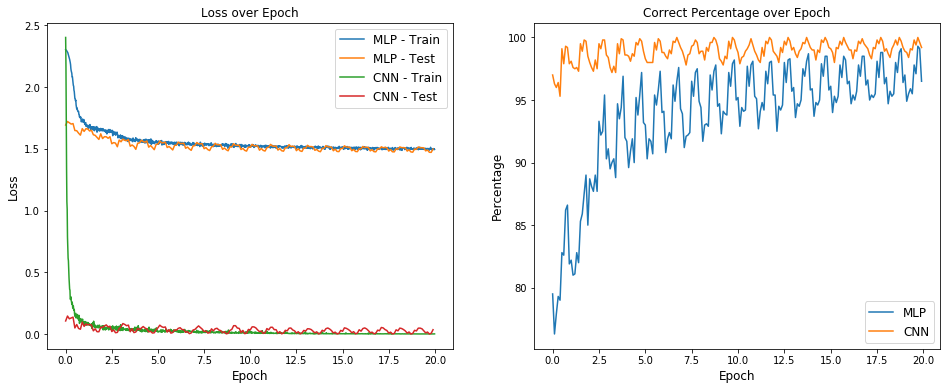

In [23]:
fig = plt.figure(figsize=(16, 6))

s1 = fig.add_subplot(121)
s1.set_title('Loss over Epoch', fontsize=12)
s1.set_xlabel('Epoch', fontsize=12)
s1.set_ylabel('Loss', fontsize=12)
s1.plot(train_x, train_losses, label='MLP - Train')
s1.plot(test_x, test_losses, label='MLP - Test')
s1.plot(cnn_train_x, cnn_train_losses, label='CNN - Train')
s1.plot(cnn_test_x, cnn_test_losses, label='CNN - Test')
s1.legend(['MLP - Train', 'MLP - Test', 'CNN - Train', 'CNN - Test'], loc='upper right', fontsize=12)

s2 = fig.add_subplot(122)
s2.set_title('Correct Percentage over Epoch', fontsize=12)
s2.set_xlabel('Epoch', fontsize=12)
s2.set_ylabel('Percentage', fontsize=12)
s2.plot(test_x, test_percentages, label='MLP')
s2.plot(cnn_test_x, cnn_test_percentages, label='CNN')
s2.legend(['MLP', 'CNN'], loc='lower right', fontsize=12)
plt.show()

## References

This tutorial highlighted just a few elements of a powerful library PyTorch. Some of the graphs are taken from other websites and are cited here.

1. WikiPedia: https://upload.wikimedia.org/wikipedia/commons/2/27/MnistExamples.png
2. Brain Neuron Structure: https://static1.squarespace.com/static/5877e0091b631b1b2c8ac78d/t/58f559619f7456166b64c409/1492474211520/
3. Multiple Layer Perceptrons Structure: http://ieeexplore.ieee.org/mediastore/IEEE/content/media/7728/7229393/7219432/7219432-fig-2-large.gif
4. Convolutional Neural Network Structure: https://cdn-images-1.medium.com/max/1600/1*_34EtrgYk6cQxlJ2br51HQ.gif
5. PyTorch: http://pytorch.org